# Fligh Delay Prediction

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Dataframe creation

In [2]:
airlines = pd.read_csv('Data/airlines.csv')
airports = pd.read_csv('Data/airports.csv')
flights = pd.read_csv('Data/flights.csv',low_memory=False)
flights = flights.sample(frac=0.2, random_state=10)

In [22]:
# merge airlines and flights into another dataframe for EDA and analysis
merged_data = pd.merge(flights, airlines, left_on='AIRLINE', right_on='IATA_CODE', how='left')
merged_data = merged_data.drop('IATA_CODE', axis=1)
merged_data = merged_data.rename(columns={'AIRLINE_x': 'AIRLINE', 'AIRLINE_y': 'AIRLINE_NAME'})
#merge airport
merged_data = pd.merge(merged_data, airports, left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how='left')
merged_data = merged_data.drop('IATA_CODE', axis=1)
merged_data = merged_data.rename(columns={'AIRPORT': 'ORIGIN_AIRPORT_NAME'})

In [3]:
pd.set_option('display.max_columns', None)

### Some preprocessings

In [4]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
411984,2015,1,28,3,WN,103,N7728D,DCA,MKE,705,713.0,8.0,12.0,725.0,125.0,118.0,102.0,634,807.0,4.0,810,811.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3591965,2015,8,11,2,B6,153,N592JB,JFK,PBI,1859,111.0,372.0,16.0,127.0,189.0,154.0,134.0,1028,341.0,4.0,2208,345.0,337.0,0,0,NaN,0.0,0.0,82.0,255.0,0.0
526451,2015,2,4,3,DL,1187,N921DN,MSP,DCA,1735,1734.0,-1.0,13.0,1747.0,147.0,129.0,111.0,931,2038.0,5.0,2102,2043.0,-19.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1336011,2015,3,27,5,WN,171,N407WN,DEN,RDU,1815,1807.0,-8.0,9.0,1816.0,185.0,186.0,173.0,1436,2309.0,4.0,2320,2313.0,-7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3424502,2015,8,1,6,WN,4330,N7751A,ATL,RIC,2125,2151.0,26.0,18.0,2209.0,100.0,87.0,63.0,481,2312.0,6.0,2305,2318.0,13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
flights.isnull().sum()


YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER               2979
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           17428
DEPARTURE_DELAY          17428
TAXI_OUT                 17982
WHEELS_OFF               17982
SCHEDULED_TIME               4
ELAPSED_TIME             21162
AIR_TIME                 21162
DISTANCE                     0
WHEELS_ON                18621
TAXI_IN                  18621
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             18621
ARRIVAL_DELAY            21162
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    1145673
AIR_SYSTEM_DELAY        952006
SECURITY_DELAY          952006
AIRLINE_DELAY           952006
LATE_AIRCRAFT_DELAY     952006
WEATHER_DELAY           952006
dtype: int64

In [6]:
# drop the columns specified because they have too many missing values
flights = flights.drop(['TAIL_NUMBER','CANCELLATION_REASON','AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY'],axis=1)

In [7]:
# drop the rows with missing values
flights = flights.dropna()

### Exploratory Data Analysis

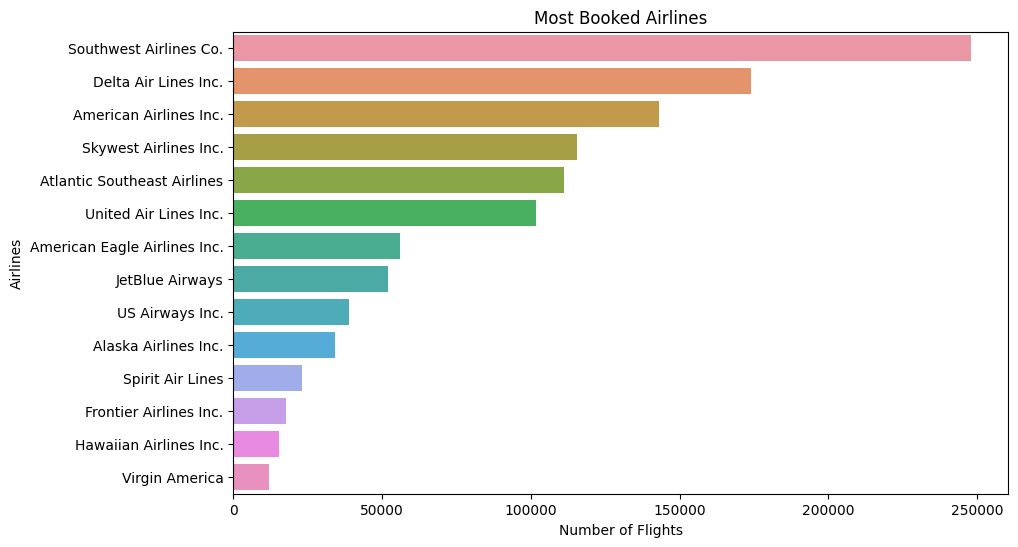

In [23]:
# most booked airlines
plt.figure(figsize=(10,6))
sns.countplot(y='AIRLINE_NAME', data=merged_data, order=merged_data['AIRLINE_NAME'].value_counts().index)
plt.title('Most Booked Airlines')
plt.xlabel('Number of Flights')
plt.ylabel('Airlines')
plt.show()

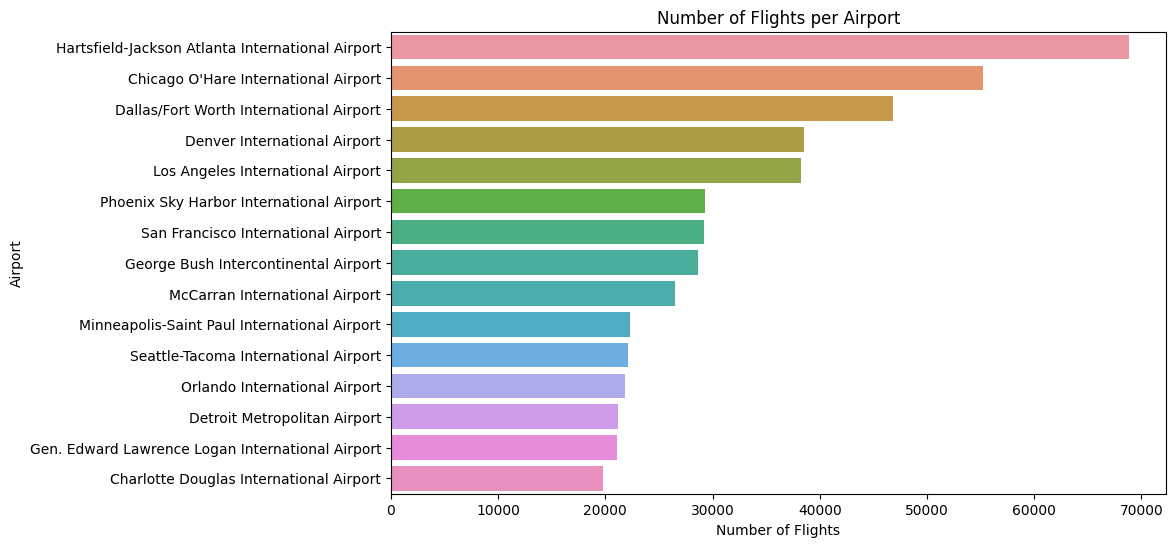

In [24]:
# most common flight routes
plt.figure(figsize=(10,6))
sns.countplot(y='ORIGIN_AIRPORT_NAME',data=merged_data,order=merged_data['ORIGIN_AIRPORT_NAME'].value_counts().iloc[:15].index)
plt.xlabel('Number of Flights')
plt.ylabel('Airport')
plt.title('Number of Flights per Airport')
plt.show()

/var/folders/lb/0kvsq4m52xz_pn_8rxgbr5lm0000gn/T/ipykernel_10442/2001840176.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='ARRIVAL_DELAY',y='AIRLINE_NAME',data=merged_data,estimator=np.mean,ci=None,order=merged_data.groupby('AIRLINE_NAME').ARRIVAL_DELAY.mean().sort_values(ascending=False).index)


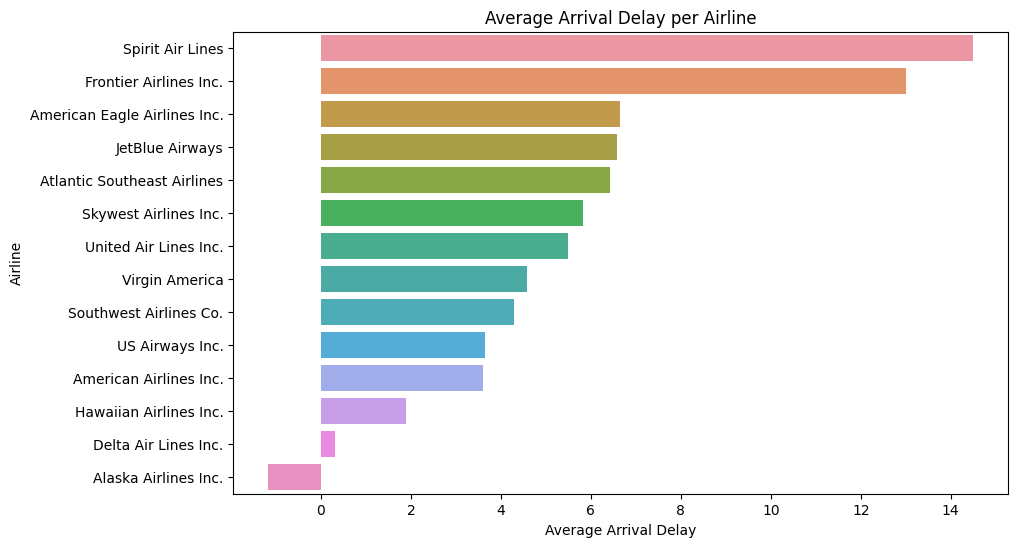

In [25]:
# what is the average arrival delay for each airline write the full name of the airline
plt.figure(figsize=(10,6))
sns.barplot(x='ARRIVAL_DELAY',y='AIRLINE_NAME',data=merged_data,estimator=np.mean,ci=None,order=merged_data.groupby('AIRLINE_NAME').ARRIVAL_DELAY.mean().sort_values(ascending=False).index)
plt.xlabel('Average Arrival Delay')
plt.ylabel('Airline')
plt.title('Average Arrival Delay per Airline')
plt.show()

/var/folders/lb/0kvsq4m52xz_pn_8rxgbr5lm0000gn/T/ipykernel_10442/3713939712.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='ARRIVAL_DELAY',y='ORIGIN_AIRPORT_NAME',data=merged_data,estimator=np.mean,ci=None,order=merged_data.groupby('ORIGIN_AIRPORT_NAME').ARRIVAL_DELAY.mean().sort_values(ascending=False).iloc[:15].index)


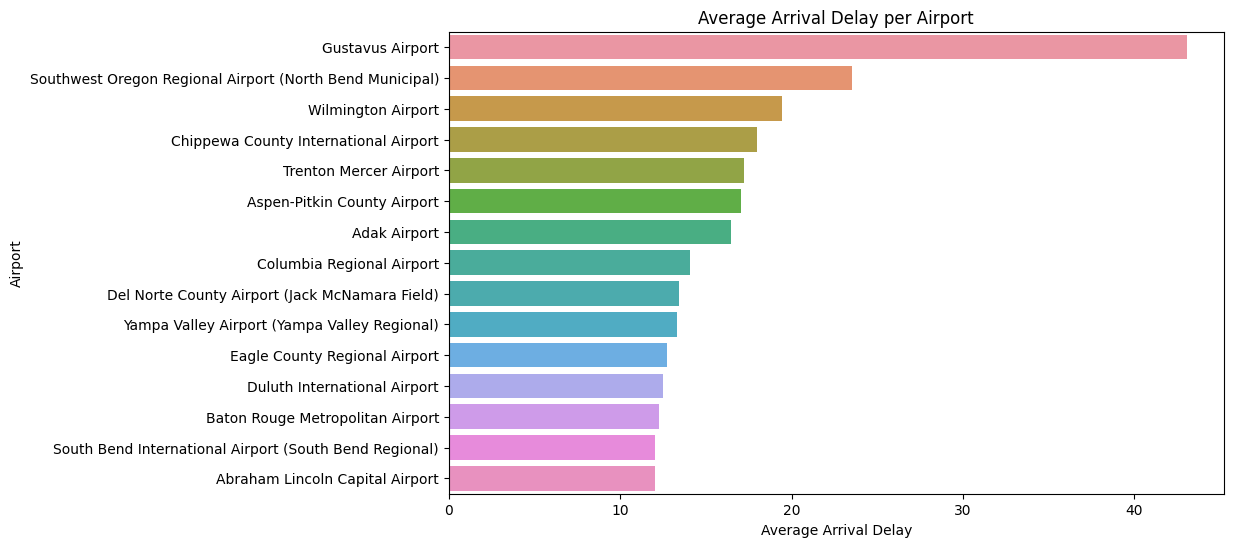

In [26]:
# what is the average arrival delay for each airport
plt.figure(figsize=(10,6))
sns.barplot(x='ARRIVAL_DELAY',y='ORIGIN_AIRPORT_NAME',data=merged_data,estimator=np.mean,ci=None,order=merged_data.groupby('ORIGIN_AIRPORT_NAME').ARRIVAL_DELAY.mean().sort_values(ascending=False).iloc[:15].index)
plt.xlabel('Average Arrival Delay')
plt.ylabel('Airport')
plt.title('Average Arrival Delay per Airport')
plt.show()

/var/folders/lb/0kvsq4m52xz_pn_8rxgbr5lm0000gn/T/ipykernel_10442/2582719996.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='DEPARTURE_DELAY',y='AIRLINE_NAME',data=merged_data,estimator=np.mean,ci=None,order=merged_data.groupby('AIRLINE_NAME').DEPARTURE_DELAY.mean().sort_values(ascending=False).index)


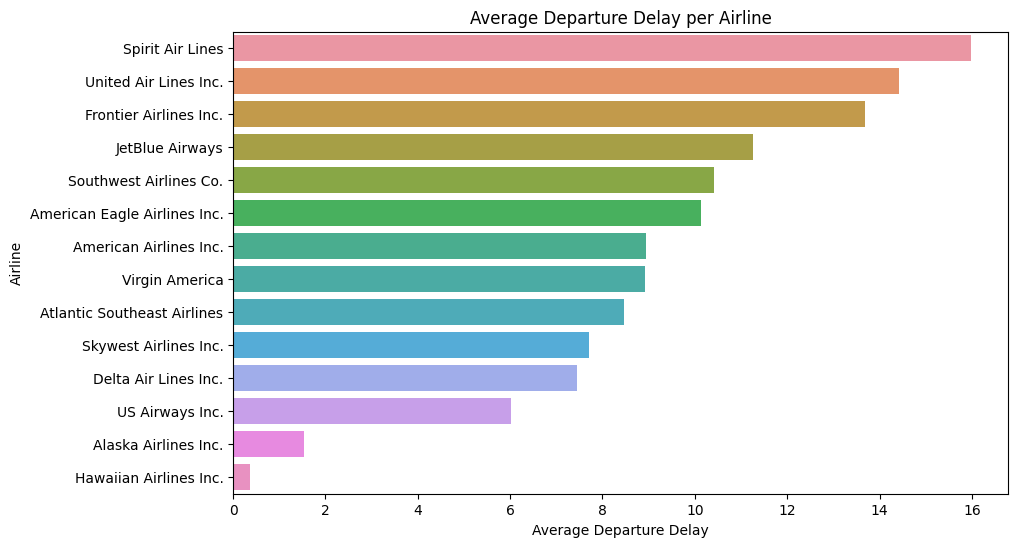

In [27]:
# what is the average departure delay for each airline
plt.figure(figsize=(10,6))
sns.barplot(x='DEPARTURE_DELAY',y='AIRLINE_NAME',data=merged_data,estimator=np.mean,ci=None,order=merged_data.groupby('AIRLINE_NAME').DEPARTURE_DELAY.mean().sort_values(ascending=False).index)
plt.xlabel('Average Departure Delay')
plt.ylabel('Airline')
plt.title('Average Departure Delay per Airline')
plt.show()

/var/folders/lb/0kvsq4m52xz_pn_8rxgbr5lm0000gn/T/ipykernel_10442/270965747.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='DEPARTURE_DELAY',y='ORIGIN_AIRPORT_NAME',data=merged_data,estimator=np.mean,ci=None,order=merged_data.groupby('ORIGIN_AIRPORT_NAME').DEPARTURE_DELAY.mean().sort_values(ascending=False).iloc[:15].index)


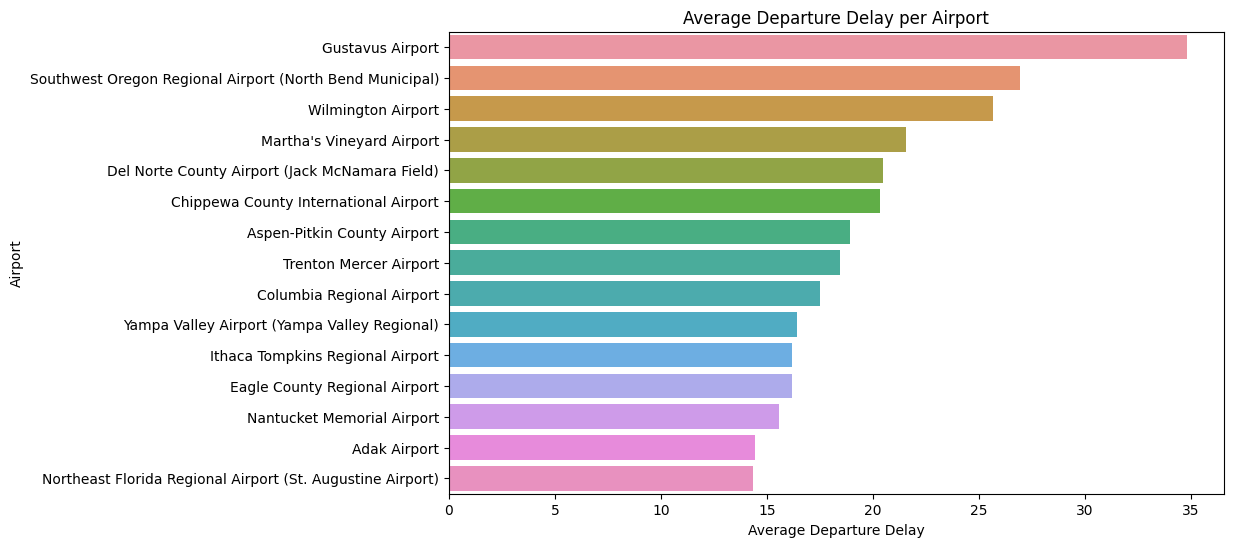

In [28]:
# what is the average departure delay for each airport
plt.figure(figsize=(10,6))
sns.barplot(x='DEPARTURE_DELAY',y='ORIGIN_AIRPORT_NAME',data=merged_data,estimator=np.mean,ci=None,order=merged_data.groupby('ORIGIN_AIRPORT_NAME').DEPARTURE_DELAY.mean().sort_values(ascending=False).iloc[:15].index)
plt.xlabel('Average Departure Delay')
plt.ylabel('Airport')
plt.title('Average Departure Delay per Airport')
plt.show()

/Users/mdehteshamansari00/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


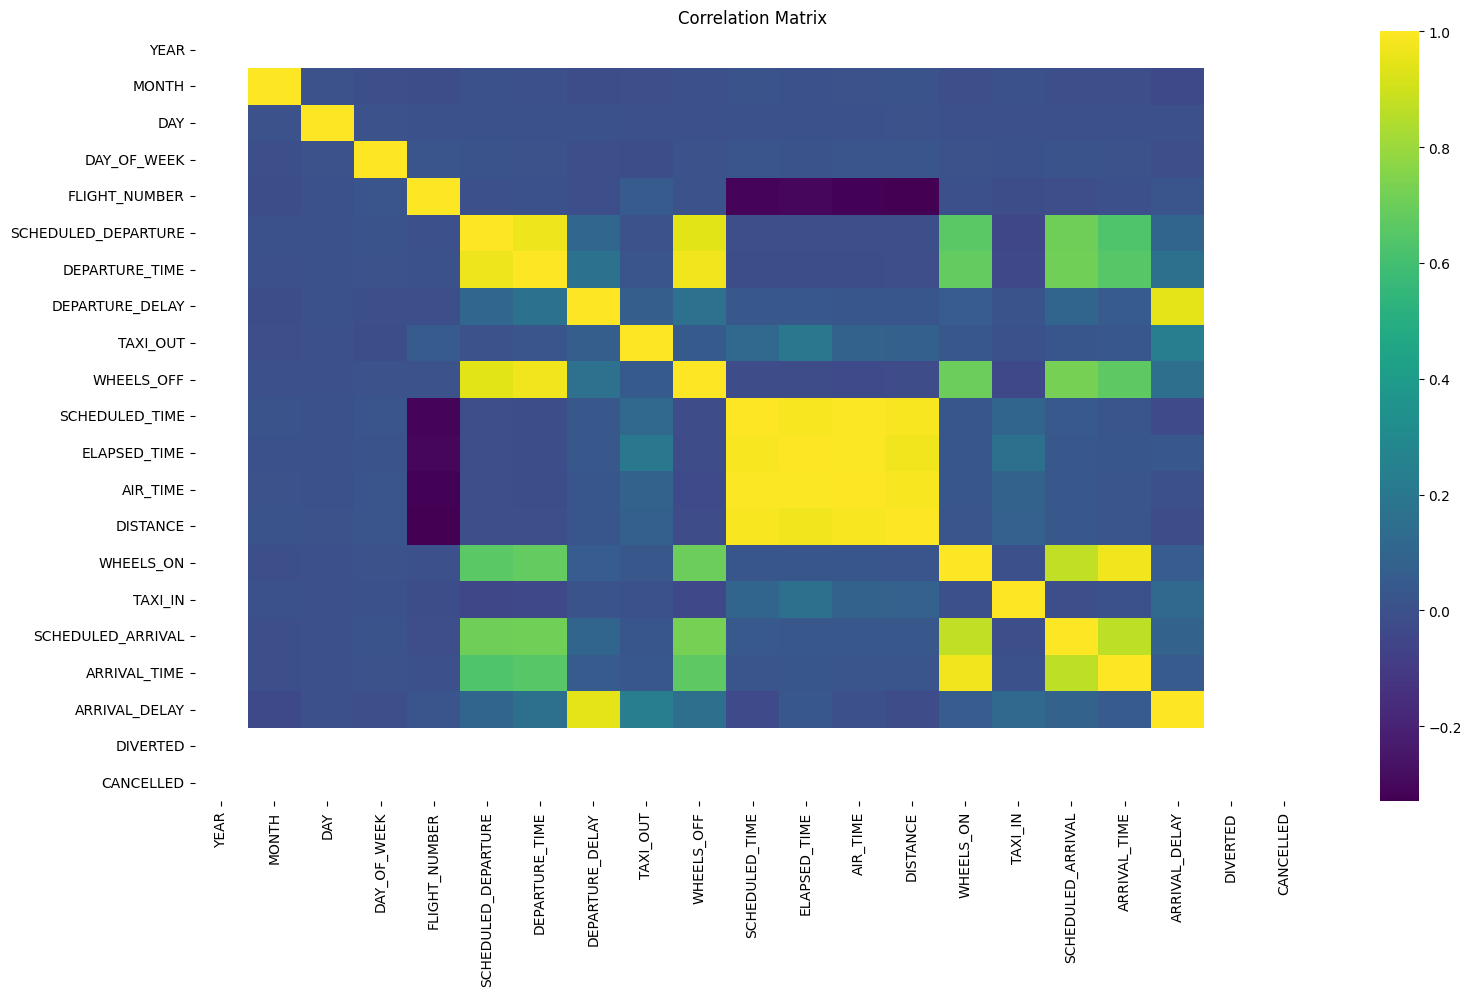

In [29]:
plt.figure(figsize=(18,10))
numeric_columns = flights.select_dtypes(include=np.number).columns
sns.heatmap(flights[numeric_columns].corr(), annot=True, cmap='viridis')
plt.title('Correlation Matrix')
plt.show()

/Users/mdehteshamansari00/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


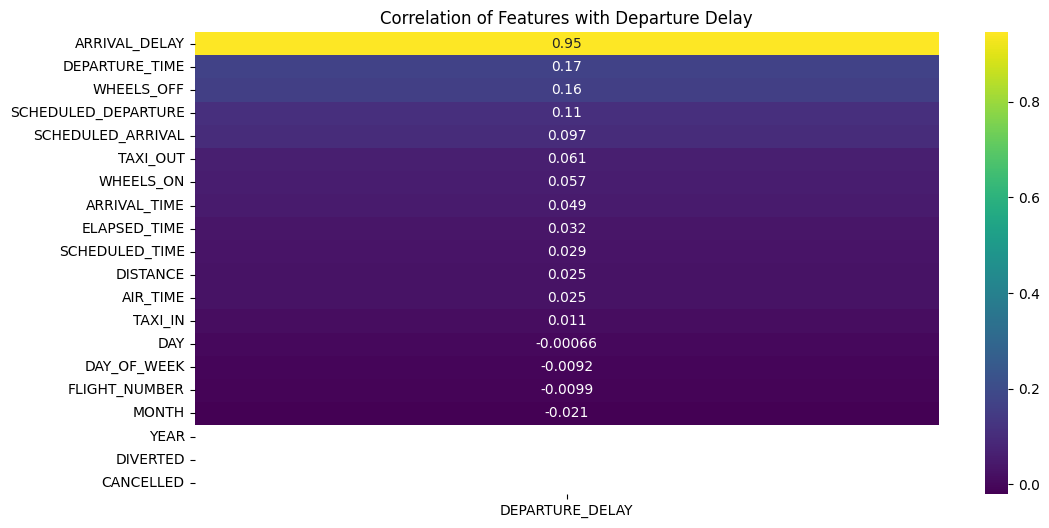

In [30]:
numeric_columns = flights.select_dtypes(include=np.number).columns
numeric_columns.correlation = flights[numeric_columns].corr()
plt.figure(figsize=(12,6))
sns.heatmap(numeric_columns.correlation['DEPARTURE_DELAY'].sort_values(ascending=False)[1:].to_frame(), annot=True, cmap='viridis')
plt.title('Correlation of Features with Departure Delay')
plt.show()

In [31]:
#only keep these columns for the model and ignore the rest because they are not useful for prediction
flights = flights[['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DEPARTURE_DELAY', 'DISTANCE', 'ARRIVAL_DELAY']]

In [32]:
# merge the airports data with the flights data
flights.loc[~flights.ORIGIN_AIRPORT.isin(airports.IATA_CODE.values),'ORIGIN_AIRPORT']='OTHER'
flights.loc[~flights.DESTINATION_AIRPORT.isin(airports.IATA_CODE.values),'DESTINATION_AIRPORT']='OTHER'
flights

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,DISTANCE,ARRIVAL_DELAY
411984,1,28,3,WN,DCA,MKE,705,8.0,634,1.0
3591965,8,11,2,B6,JFK,PBI,1859,372.0,1028,337.0
526451,2,4,3,DL,MSP,DCA,1735,-1.0,931,-19.0
1336011,3,27,5,WN,DEN,RDU,1815,-8.0,1436,-7.0
3424502,8,1,6,WN,ATL,RIC,2125,26.0,481,13.0
...,...,...,...,...,...,...,...,...,...,...
821670,2,24,2,DL,LAS,ATL,600,5.0,1747,-14.0
4672701,10,19,1,WN,OTHER,OTHER,835,-5.0,258,6.0
1440098,4,3,5,NK,FLL,BOS,800,-7.0,1237,-3.0
750362,2,19,4,UA,IAH,EGE,1131,-4.0,934,-5.0


In [33]:
flights.dropna(inplace=True)

In [34]:
df=pd.DataFrame(flights)
df['DAY_OF_WEEK']= df['DAY_OF_WEEK'].apply(str)
df["DAY_OF_WEEK"].replace({"1":"SUNDAY", "2": "MONDAY", "3": "TUESDAY", "4":"WEDNESDAY", "5":"THURSDAY", "6":"FRIDAY", "7":"SATURDAY"},inplace=True)
flights=df
flights

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,DISTANCE,ARRIVAL_DELAY
411984,1,28,TUESDAY,WN,DCA,MKE,705,8.0,634,1.0
3591965,8,11,MONDAY,B6,JFK,PBI,1859,372.0,1028,337.0
526451,2,4,TUESDAY,DL,MSP,DCA,1735,-1.0,931,-19.0
1336011,3,27,THURSDAY,WN,DEN,RDU,1815,-8.0,1436,-7.0
3424502,8,1,FRIDAY,WN,ATL,RIC,2125,26.0,481,13.0
...,...,...,...,...,...,...,...,...,...,...
821670,2,24,MONDAY,DL,LAS,ATL,600,5.0,1747,-14.0
4672701,10,19,SUNDAY,WN,OTHER,OTHER,835,-5.0,258,6.0
1440098,4,3,THURSDAY,NK,FLL,BOS,800,-7.0,1237,-3.0
750362,2,19,WEDNESDAY,UA,IAH,EGE,1131,-4.0,934,-5.0


In [35]:
dums = ['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','DAY_OF_WEEK']
flights_encoded=pd.get_dummies(df[dums],drop_first=True)
flights_encoded

,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,AIRLINE_UA,AIRLINE_US,AIRLINE_VX,AIRLINE_WN,ORIGIN_AIRPORT_ABI,ORIGIN_AIRPORT_ABQ,ORIGIN_AIRPORT_ABR,ORIGIN_AIRPORT_ABY,ORIGIN_AIRPORT_ACK,ORIGIN_AIRPORT_ACT,ORIGIN_AIRPORT_ACV,ORIGIN_AIRPORT_ACY,ORIGIN_AIRPORT_ADK,ORIGIN_AIRPORT_ADQ,ORIGIN_AIRPORT_AEX,ORIGIN_AIRPORT_AGS,ORIGIN_AIRPORT_AKN,ORIGIN_AIRPORT_ALB,ORIGIN_AIRPORT_ALO,ORIGIN_AIRPORT_AMA,ORIGIN_AIRPORT_ANC,ORIGIN_AIRPORT_APN,ORIGIN_AIRPORT_ASE,ORIGIN_AIRPORT_ATL,ORIGIN_AIRPORT_ATW,ORIGIN_AIRPORT_AUS,ORIGIN_AIRPORT_AVL,ORIGIN_AIRPORT_AVP,ORIGIN_AIRPORT_AZO,ORIGIN_AIRPORT_BDL,ORIGIN_AIRPORT_BET,ORIGIN_AIRPORT_BFL,ORIGIN_AIRPORT_BGM,ORIGIN_AIRPORT_BGR,ORIGIN_AIRPORT_BHM,ORIGIN_AIRPORT_BIL,ORIGIN_AIRPORT_BIS,ORIGIN_AIRPORT_BJI,ORIGIN_AIRPORT_BLI,ORIGIN_AIRPORT_BMI,ORIGIN_AIRPORT_BNA,ORIGIN_AIRPORT_BOI,ORIGIN_AIRPORT_BOS,ORIGIN_AIRPORT_BPT,ORIGIN_AIRPORT_BQK,ORIGIN_AIRPORT_BQN,ORIGIN_AIRPORT_BRD,ORIGIN_AIRPORT_BRO,ORIGIN_AIRPORT_BRW,ORIGIN_AIRPORT_BTM,ORIGIN_AIRPORT_BTR,ORIGIN_AIRPORT_BTV,ORIGIN_AIRPORT_BUF,ORIGIN_AIRPORT_BUR,ORIGIN_AIRPORT_BWI,ORIGIN_AIRPORT_BZN,ORIGIN_AIRPORT_CAE,ORIGIN_AIRPORT_CAK,ORIGIN_AIRPORT_CDC,ORIGIN_AIRPORT_CDV,ORIGIN_AIRPORT_CEC,ORIGIN_AIRPORT_CHA,ORIGIN_AIRPORT_CHO,ORIGIN_AIRPORT_CHS,ORIGIN_AIRPORT_CID,ORIGIN_AIRPORT_CIU,ORIGIN_AIRPORT_CLD,ORIGIN_AIRPORT_CLE,ORIGIN_AIRPORT_CLL,ORIGIN_AIRPORT_CLT,ORIGIN_AIRPORT_CMH,ORIGIN_AIRPORT_CMI,ORIGIN_AIRPORT_CMX,ORIGIN_AIRPORT_CNY,ORIGIN_AIRPORT_COD,ORIGIN_AIRPORT_COS,ORIGIN_AIRPORT_COU,ORIGIN_AIRPORT_CPR,ORIGIN_AIRPORT_CRP,ORIGIN_AIRPORT_CRW,ORIGIN_AIRPORT_CSG,ORIGIN_AIRPORT_CVG,ORIGIN_AIRPORT_CWA,ORIGIN_AIRPORT_DAB,ORIGIN_AIRPORT_DAL,ORIGIN_AIRPORT_DAY,ORIGIN_AIRPORT_DBQ,ORIGIN_AIRPORT_DCA,ORIGIN_AIRPORT_DEN,ORIGIN_AIRPORT_DFW,ORIGIN_AIRPORT_DHN,ORIGIN_AIRPORT_DIK,ORIGIN_AIRPORT_DLG,ORIGIN_AIRPORT_DLH,ORIGIN_AIRPORT_DRO,ORIGIN_AIRPORT_DSM,ORIGIN_AIRPORT_DTW,ORIGIN_AIRPORT_DVL,ORIGIN_AIRPORT_EAU,ORIGIN_AIRPORT_ECP,ORIGIN_AIRPORT_EGE,ORIGIN_AIRPORT_EKO,ORIGIN_AIRPORT_ELM,ORIGIN_AIRPORT_ELP,ORIGIN_AIRPORT_ERI,ORIGIN_AIRPORT_ESC,ORIGIN_AIRPORT_EUG,ORIGIN_AIRPORT_EVV,ORIGIN_AIRPORT_EWN,ORIGIN_AIRPORT_EWR,ORIGIN_AIRPORT_EYW,ORIGIN_AIRPORT_FAI,ORIGIN_AIRPORT_FAR,ORIGIN_AIRPORT_FAT,ORIGIN_AIRPORT_FAY,ORIGIN_AIRPORT_FCA,ORIGIN_AIRPORT_FLG,ORIGIN_AIRPORT_FLL,ORIGIN_AIRPORT_FNT,ORIGIN_AIRPORT_FSD,ORIGIN_AIRPORT_FSM,ORIGIN_AIRPORT_FWA,ORIGIN_AIRPORT_GCC,ORIGIN_AIRPORT_GCK,ORIGIN_AIRPORT_GEG,ORIGIN_AIRPORT_GFK,ORIGIN_AIRPORT_GGG,ORIGIN_AIRPORT_GJT,ORIGIN_AIRPORT_GNV,ORIGIN_AIRPORT_GPT,ORIGIN_AIRPORT_GRB,ORIGIN_AIRPORT_GRI,ORIGIN_AIRPORT_GRK,ORIGIN_AIRPORT_GRR,ORIGIN_AIRPORT_GSO,ORIGIN_AIRPORT_GSP,ORIGIN_AIRPORT_GST,ORIGIN_AIRPORT_GTF,ORIGIN_AIRPORT_GTR,ORIGIN_AIRPORT_GUC,ORIGIN_AIRPORT_GUM,ORIGIN_AIRPORT_HDN,ORIGIN_AIRPORT_HIB,ORIGIN_AIRPORT_HLN,ORIGIN_AIRPORT_HNL,ORIGIN_AIRPORT_HOB,ORIGIN_AIRPORT_HOU,ORIGIN_AIRPORT_HPN,ORIGIN_AIRPORT_HRL,ORIGIN_AIRPORT_HSV,ORIGIN_AIRPORT_HYA,ORIGIN_AIRPORT_HYS,ORIGIN_AIRPORT_IAD,ORIGIN_AIRPORT_IAG,ORIGIN_AIRPORT_IAH,ORIGIN_AIRPORT_ICT,ORIGIN_AIRPORT_IDA,ORIGIN_AIRPORT_ILG,ORIGIN_AIRPORT_ILM,ORIGIN_AIRPORT_IMT,ORIGIN_AIRPORT_IND,ORIGIN_AIRPORT_INL,ORIGIN_AIRPORT_ISN,ORIGIN_AIRPORT_ISP,ORIGIN_AIRPORT_ITH,ORIGIN_AIRPORT_ITO,ORIGIN_AIRPORT_JAC,ORIGIN_AIRPORT_JAN,ORIGIN_AIRPORT_JAX,ORIGIN_AIRPORT_JFK,ORIGIN_AIRPORT_JLN,ORIGIN_AIRPORT_JMS,ORIGIN_AIRPORT_JNU,ORIGIN_AIRPORT_KOA,ORIGIN_AIRPORT_KTN,ORIGIN_AIRPORT_LAN,ORIGIN_AIRPORT_LAR,ORIGIN_AIRPORT_LAS,ORIGIN_AIRPORT_LAW,ORIGIN_AIRPORT_LAX,ORIGIN_AIRPORT_LBB,ORIGIN_AIRPORT_LBE,ORIGIN_AIRPORT_LCH,ORIGIN_AIRPORT_LEX,ORIGIN_AIRPORT_LFT,ORIGIN_AIRPORT_LGA,ORIGIN_AIRPORT_LGB,ORIGIN_AIRPORT_LIH,ORIGIN_AIRPORT_LIT,ORIGIN_AIRPORT_LNK,ORIGIN_AIRPORT_LRD,ORIGIN_AIRPORT_LSE,ORIGIN_AIRPORT_LWS,ORIGIN_AIRPORT_MAF,ORIGIN_AIRPORT_MBS,ORIGIN_AIRPORT_MCI,ORIGIN_AIRPORT_MCO,ORIGIN_AIRPORT_MDT,ORIGIN_AIRPORT_MDW,ORIGIN_AIRPORT_MEI,ORIGIN_AIRPORT_MEM,ORIGIN_AIRPORT_MFE,ORIGIN_AIRPORT_MFR,ORIGIN_AIRPORT_MGM,ORIGIN_AIRPORT_MHK,ORIGIN_AIRPORT_MHT,ORIGIN_AIRPORT_MIA

In [36]:
flights.drop(dums,axis=1,inplace=True)

In [37]:
data = pd.concat([flights,flights_encoded],axis=1)

In [38]:
final_data = data.sample(n=60000, random_state=10)

### Modelling

In [39]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [40]:
X = final_data.drop('DEPARTURE_DELAY',axis=1)
y = final_data['DEPARTURE_DELAY']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [42]:
# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [43]:
rf_rmse = np.sqrt(metrics.mean_squared_error(y_test, rf_pred))
rf_rmse

9.928551248238026

In [44]:
rf_score = rf.score(X_test, y_test)
rf_score

0.9232253026042853

In [45]:
# Decision Tree
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [46]:
dt_rmse = np.sqrt(metrics.mean_squared_error(y_test, dt_pred))  
dt_rmse

13.710057135791471

In [47]:
dt_score = dt.score(X_test, y_test)
dt_score

0.8536054601110514

In [48]:
# Gradient Boosting
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

In [49]:
gb_rmse = np.sqrt(metrics.mean_squared_error(y_test, gb_pred))
gb_rmse

9.700183654577225

In [50]:
gb_score = gb.score(X_test, y_test)
gb_score

0.9267164897914736

In [51]:
# Compare the models
models = [ 'Random Forest', 'Decision Tree', 'Gradient Boosting']
scores = [rf_score, dt_score, gb_score]
rmses = [rf_rmse, dt_rmse, gb_rmse]

model_comparison = pd.DataFrame({'Model': models, 'Score': scores, 'RMSE': rmses})
model_comparison


,Model,Score,RMSE
0,Random Forest,0.923225,9.928551
1,Decision Tree,0.853605,13.710057
2,Gradient Boosting,0.926716,9.700184


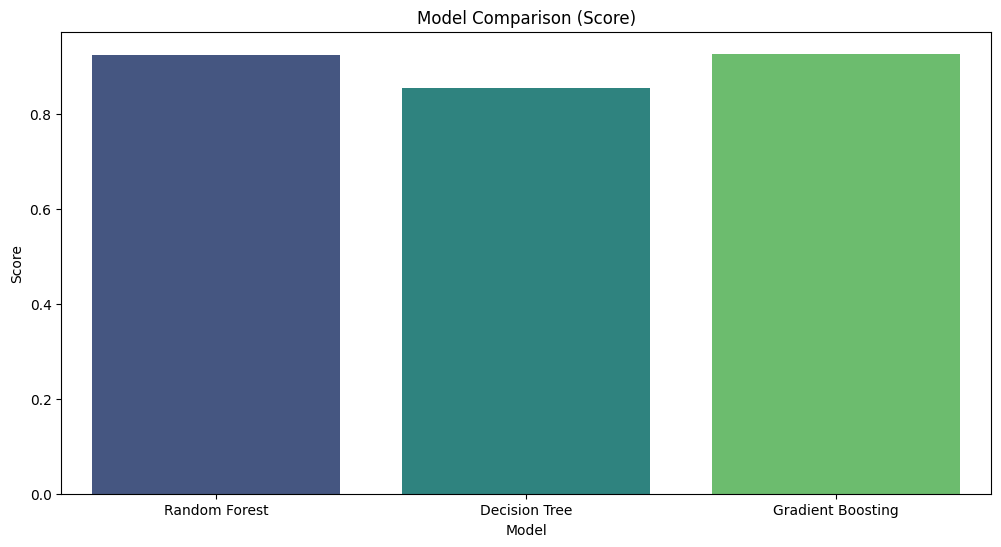

In [52]:
# visualize the comparison
plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='Score', data=model_comparison, palette='viridis')
plt.title('Model Comparison (Score)')
plt.show()

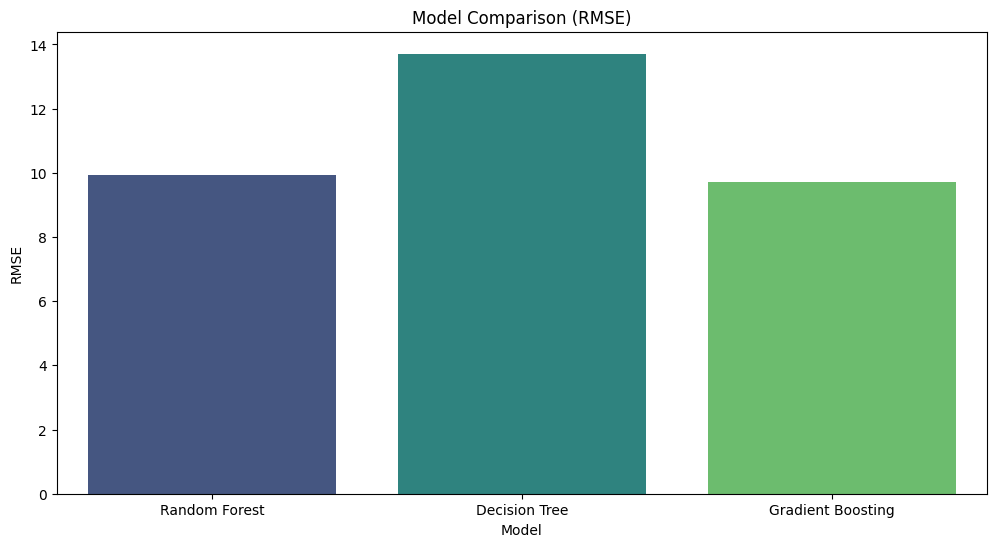

In [53]:
# visualize the comparison
plt.figure(figsize=(12,6))
sns.barplot(x='Model', y='RMSE', data=model_comparison, palette='viridis')
plt.title('Model Comparison (RMSE)')
plt.show()

In [55]:
# save the model
import pickle
# if model is already saved then load it or else save it
try:
    rf = pickle.load(open('model.pkl', 'rb'))
except:
    pickle.dump(rf, open('model.pkl', 'wb'))
    


In [51]:
# save the data
final_data.to_csv('final_data.csv', index=False)

### Predict for the test set and compare the actual and predicted value

In [56]:
# predict the departure delay
model = pickle.load(open('model.pkl', 'rb'))
data = pd.read_csv('final_data.csv')
data = data.drop('DEPARTURE_DELAY', axis=1)
data = data.iloc[100].values.reshape(1, -1)
prediction = model.predict(data)
prediction


/Users/mdehteshamansari00/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([-3.23])

In [57]:
# compare the prediction with the actual value
actual_value = pd.read_csv('final_data.csv')
actual_value = actual_value['DEPARTURE_DELAY'].iloc[100]
actual_value


-3.0

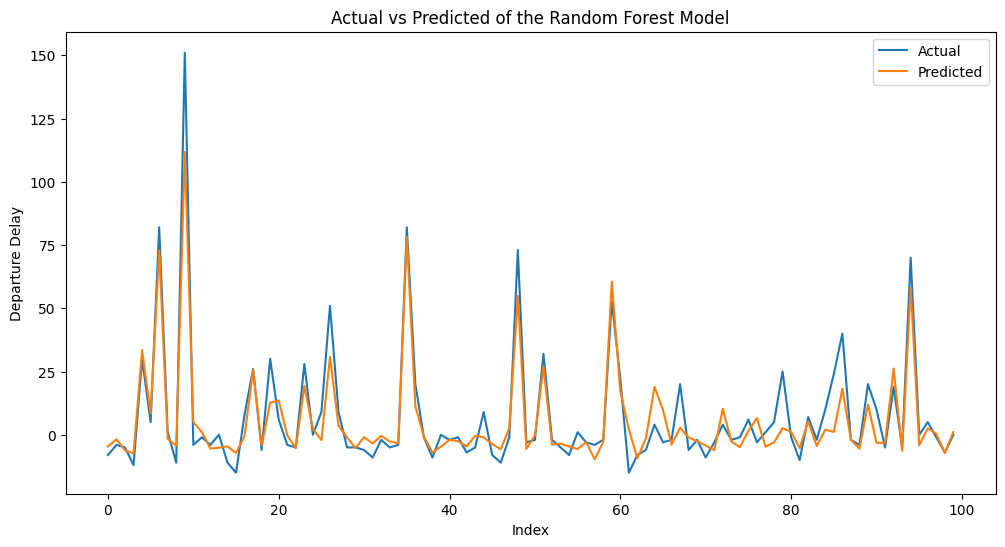

In [66]:
# plot the actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(rf_pred[:100], label='Predicted')
plt.title('Actual vs Predicted of the Random Forest Model')
plt.xlabel('Index')
plt.ylabel('Departure Delay')
plt.legend()
plt.show()
